# Heart failure OR Normal

### Import all the Dep endencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

## Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

### making a check to find out if I am in the right folder and displaying a sample image

## Import data into tensorflow dataset object 

### We will use image_dataset_from_directory api to load all images in tensorflow dataset:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory("chest_xray/train")

Found 5216 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['heart_failure', 'normal']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0]


###  As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels


## Visualize some of the images from our dataset

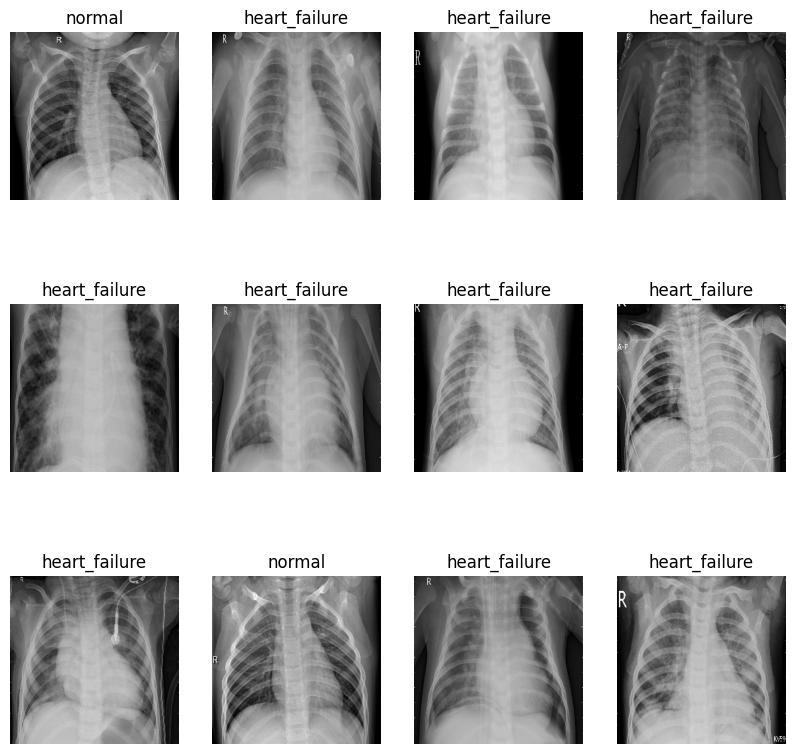

In [7]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i +1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset

### Dataset should be bifurcated into 3 subsets, namely:

#### 1. Training: Dataset to be used while training
#### 2. Validation: Dataset to be tested against while training
#### 3. Test: Dataset to be tested against after we trained a model

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

## Cache, Shuffle, and Prefetch the Dataset

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
ann = models.Sequential([
        layers.Flatten(input_shape=(256,256, 3)),
        layers.Dense(300, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax')    
    ])


In [13]:
ann.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [14]:
ann_history = ann.fit(train_ds,batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1 ,epochs=EPOCHS)

Epoch 1/5
130/130 [==============================] - 135s 252ms/step - loss: 370.9647 - accuracy: 0.7411 - val_loss: 0.6496 - val_accuracy: 0.7383
Epoch 2/5
130/130 [==============================] - 20s 151ms/step - loss: 0.6300 - accuracy: 0.7452 - val_loss: 0.6170 - val_accuracy: 0.7383
Epoch 3/5
130/130 [==============================] - 20s 151ms/step - loss: 0.6031 - accuracy: 0.7452 - val_loss: 0.5975 - val_accuracy: 0.7383
Epoch 4/5
130/130 [==============================] - 20s 152ms/step - loss: 0.5869 - accuracy: 0.7452 - val_loss: 0.5862 - val_accuracy: 0.7383
Epoch 5/5
130/130 [==============================] - 20s 154ms/step - loss: 0.5776 - accuracy: 0.7452 - val_loss: 0.5802 - val_accuracy: 0.7383


In [15]:
scores = ann.evaluate(test_ds)

17/17 [==============================] - 13s 34ms/step - loss: 0.5870 - accuracy: 0.7298


In [24]:
acc = ann_history.history['accuracy']
val_acc = ann_history.history['val_accuracy']

loss = ann_history.history['loss']
val_loss = ann_history.history['val_loss']

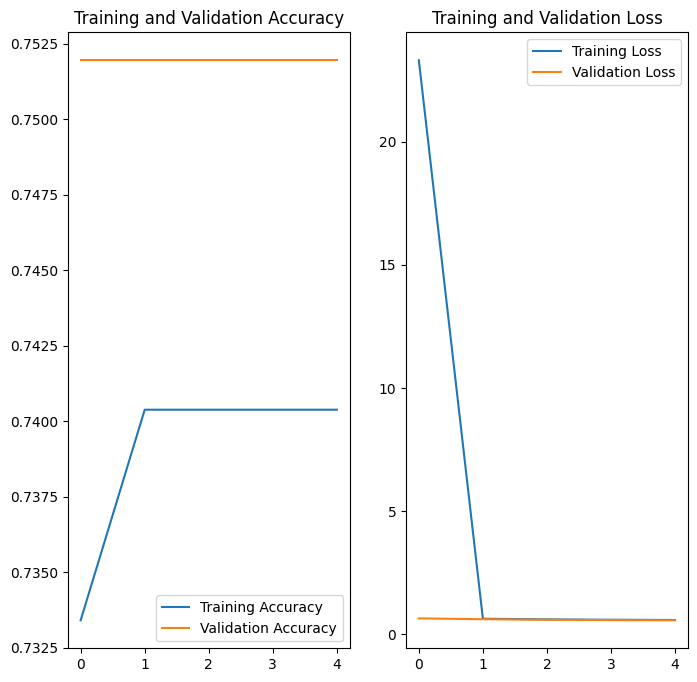

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: normal
1/1 [==============================] - 0s 37ms/step
predicted label: heart_failure


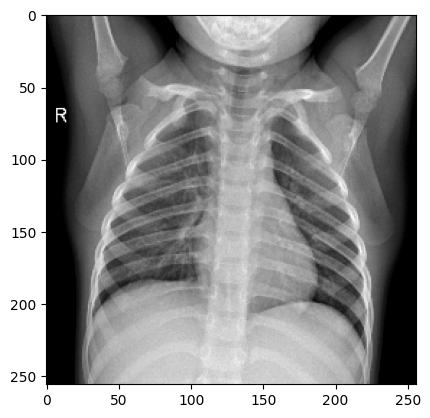

In [17]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = ann.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


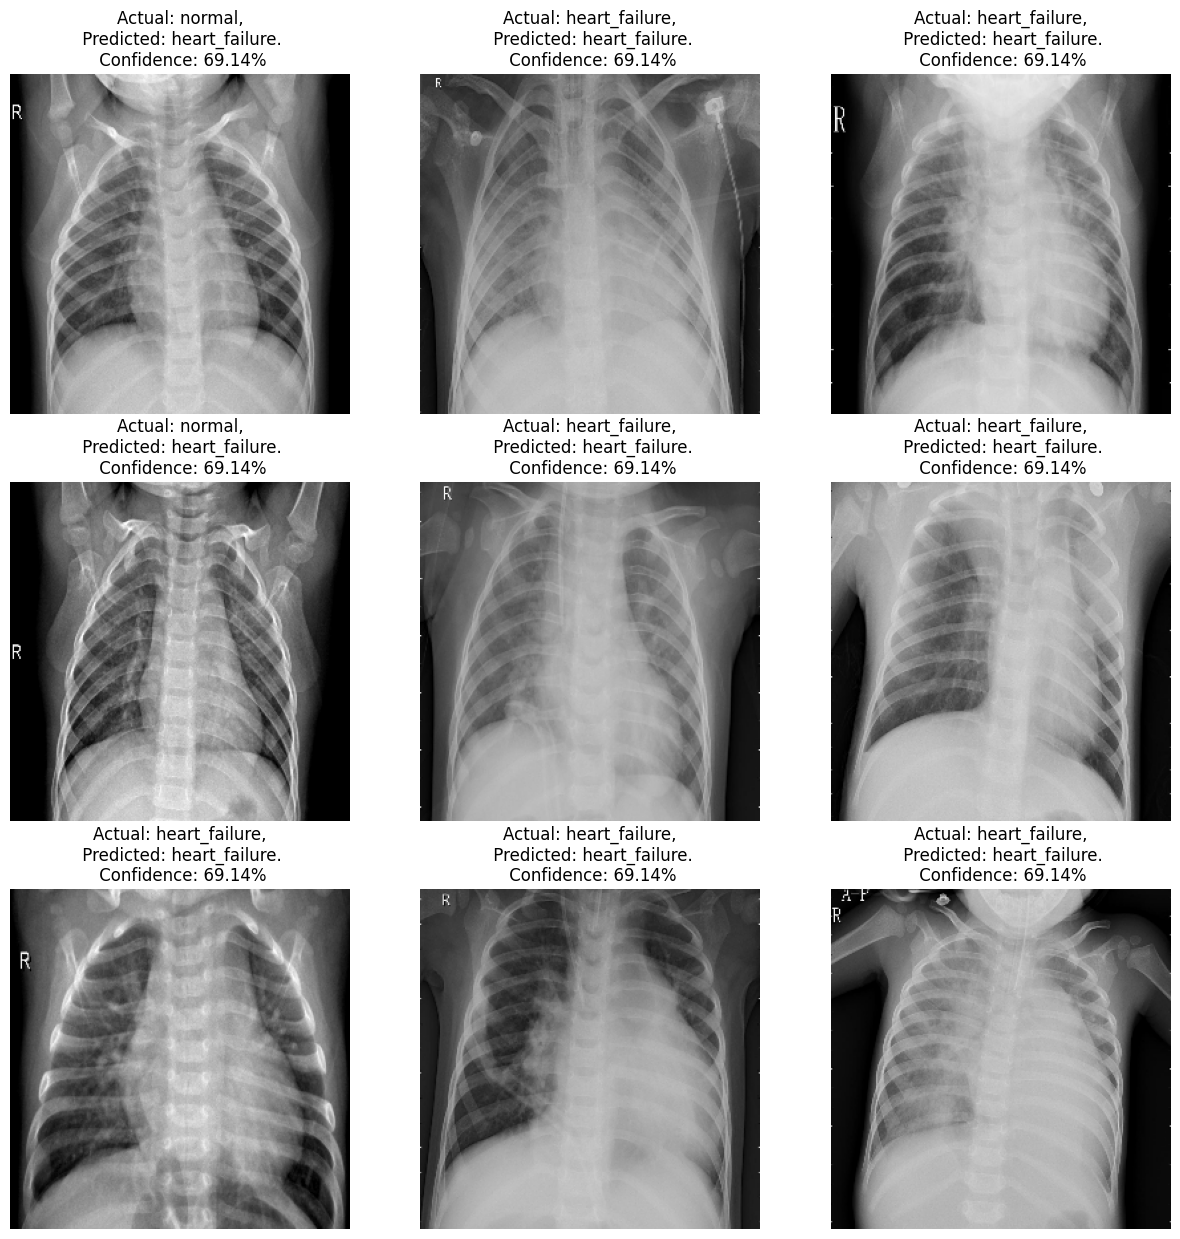

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(ann, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Time to train the model by using the model.fit

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/5
130/130 [==============================] - 58s 288ms/step - loss: 0.5589 - accuracy: 0.7524 - val_loss: 0.4785 - val_accuracy: 0.7637
Epoch 2/5
130/130 [==============================] - 37s 287ms/step - loss: 0.3375 - accuracy: 0.8599 - val_loss: 0.1635 - val_accuracy: 0.9453
Epoch 3/5
130/130 [==============================] - 37s 287ms/step - loss: 0.2157 - accuracy: 0.9132 - val_loss: 0.1397 - val_accuracy: 0.9395
Epoch 4/5
130/130 [==============================] - 37s 287ms/step - loss: 0.1983 - accuracy: 0.9272 - val_loss: 0.1278 - val_accuracy: 0.9531
Epoch 5/5
130/130 [==============================] - 37s 287ms/step - loss: 0.1758 - accuracy: 0.9312 - val_loss: 0.1034 - val_accuracy: 0.9590


# Precision, Recall, BinaryAccuracy 

#  evaluate

In [30]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
# import seaborn as sns

In [31]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 103s 70ms/step - loss: 0.1773 - accuracy: 0.9301


In [32]:
scores = model.evaluate

In [33]:
batch = next(test_ds.as_numpy_iterator())
X,y = batch
y_r =y.reshape(-1,)
print(y_r[:4])
y_pred= model.predict(X)
y_pred_classes =[np.argmax(element) for element in y_pred]
print("classification report:\n", classification_report(y_r,y_pred_classes))

[1 0 0 0]
1/1 [==============================] - 0s 409ms/step
classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.80      0.89        10

    accuracy                           0.94        32
   macro avg       0.96      0.90      0.92        32
weighted avg       0.94      0.94      0.94        32



In [34]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 130}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plotting the Accuracy and Loss Curves

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

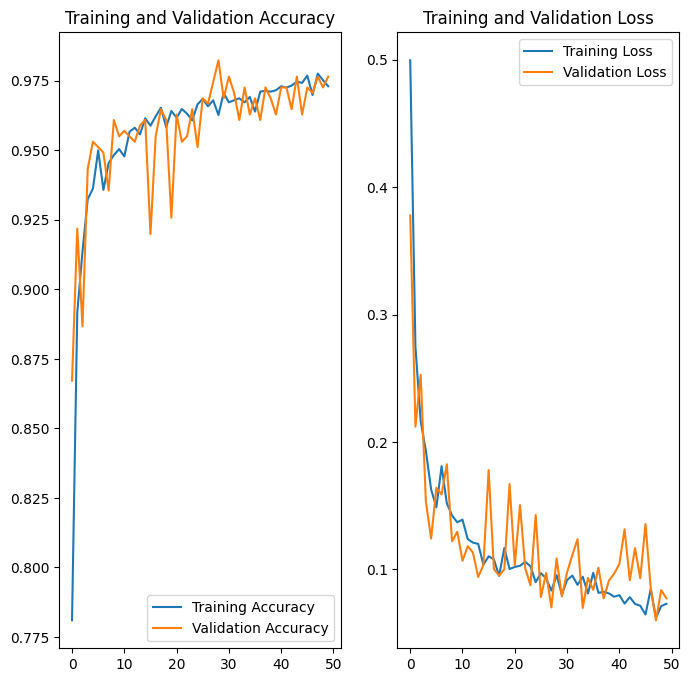

In [73]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: heart_failure
1/1 [==============================] - 0s 37ms/step
predicted label: heart_failure


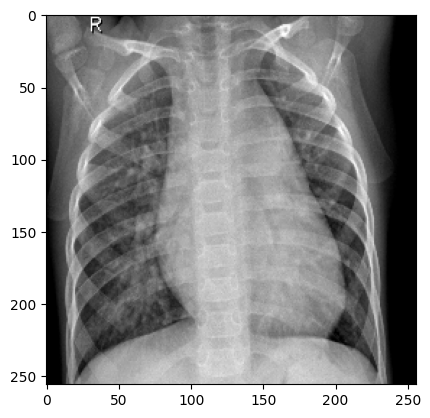

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 22ms/step


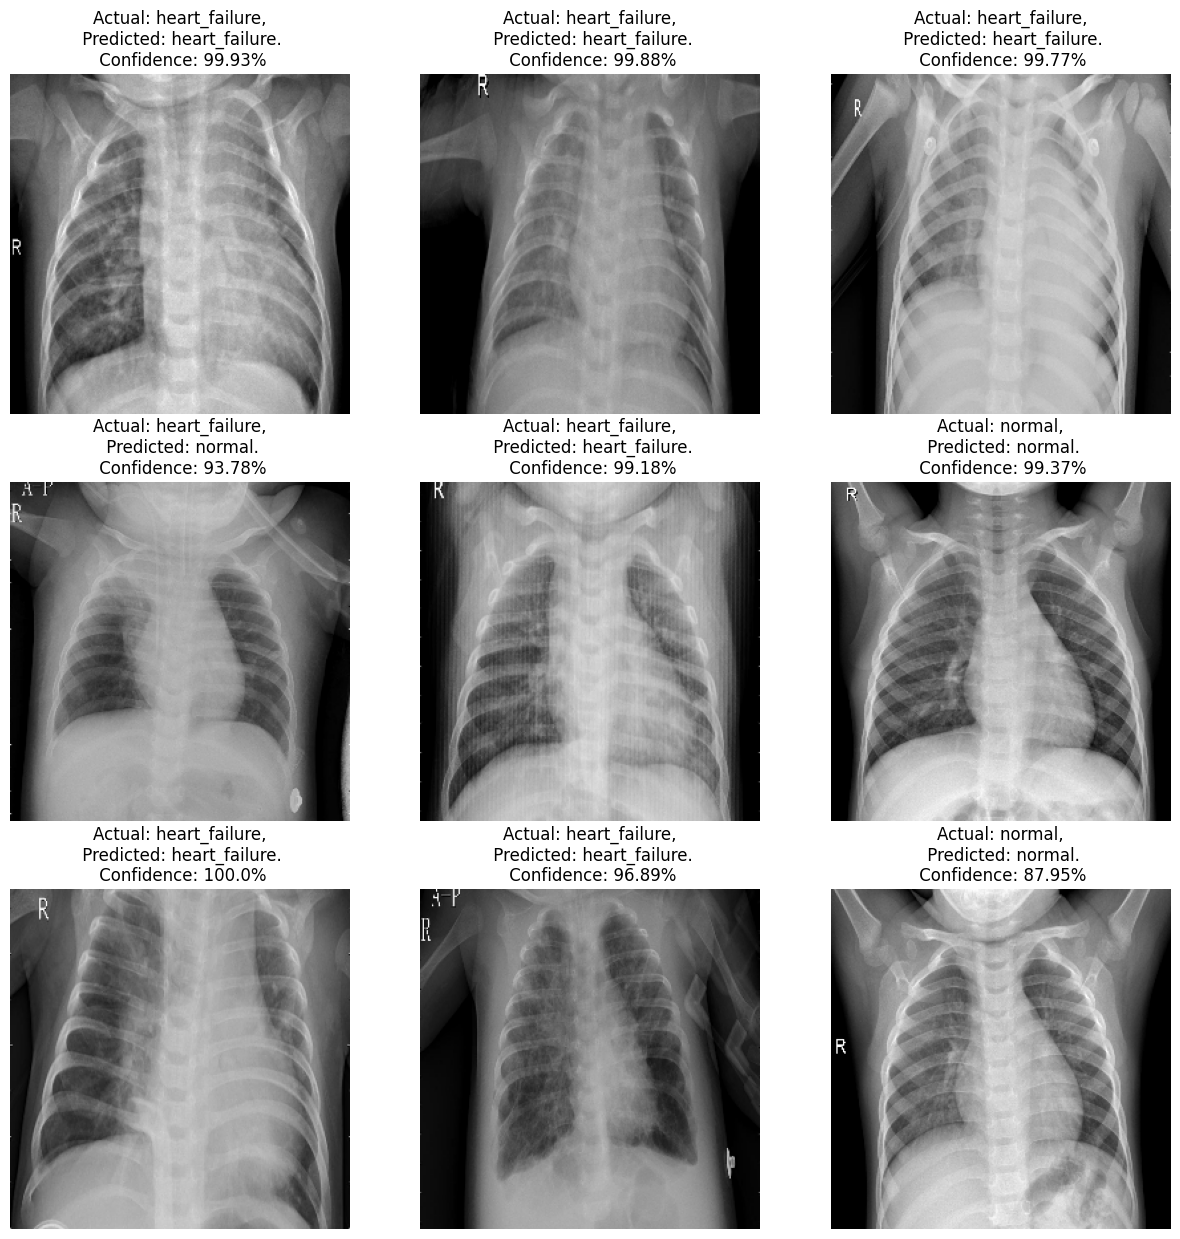

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [77]:
model.save("lungs_model.h5")

In [2]:
my_model = tf.keras.models.load_model("lungs_model.h5")

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('lungs_heart.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\winsweb\AppData\Local\Temp\tmpgqzbdito\assets


INFO:tensorflow:Assets written to: C:\Users\winsweb\AppData\Local\Temp\tmpgqzbdito\assets
